
# **Classificazione Binaria: QSO vs. Stella tramite Support Vector Machine**


Il problema che ci proponiamo di risolvere è quello di automatizzare il processo di classificazione di **QSO**(Quasi-Stellar Obeject) che, nelle immagini astronomiche, hanno una marcata somiglianza con le **stelle**. Quello che cercheremo di fare sarà, quindi, ottenere dei dataset dalla SLOAN per entrambe le categorie di oggetti in esame ed analizzarli con l'obiettivo di rimuovere dal nostro dataset tutti queli oggetti che non soddisfano i parametri di qualità fotometrica suggeriti dalla stessa SLOAN. Infine, produrremo un modello di classificazione binaria tramite le **Support Vector Machine** con l'obiettivo di avere una suddivisione delle due classi quanta più pura possibile. 

##**1. La Presa dati**
Il primo step, per la realizzazione di questo progetto, è stato ricavare i dati relativi agli oggetti in esame dall'archivio online della SDSS.
A tal proposito la SLOAN propone due tool: 


1.   Spectrospcopic Search Tool: Un tool di ricerca dati con un interfaccia molto intuitiva che permette la selezione del quantitativo di dati in output, la categoria e la gestione dei diversi flags.
https://skyserver.sdss.org/dr18/SearchTools/SQS

2.  Il secondo tool è il SQL Search, il quale tramite linguaggio SQL permette di ottenere gli stessi risultati del Tool precedente.
https://skyserver.sdss.org/dr18/SearchTools/sql#

In particolare, per la selezione di questi dati è stato adoperato l'utilizzo della SQL Search per una diretta gestione dei FLAG di qualità dei nostri cluster di dati. 

###**1.1 Il codice SQL**
Il codice usato per la selezione dati è il seguente:
```SQL
SELECT TOP 10000 
s.plate,s.mjd,s.fiberid,s.z,s.zErr,s.zWarning,s.class,p.run,p.rerun,p.camCol,p.field,p.obj,cast(str(p.ra,13,8) as float) as ra,cast(str(p.[dec],13,8) as float) as dec,p.r,p.g,p.i,p.u,p.z,p.flags_r 
FROM ..SpecObj as s 
JOIN ..PhotoObj AS p ON s.bestObjID = p.objID 
WHERE  (s.class = 'QSO') AND ( p.type = 3 OR p.type = 6) AND mode = 1 AND (p.flags & (dbo.fPhotoFlags('BAD_COUNTS_ERROR') + dbo.fPhotoFlags('COSMIC_RAY') + dbo.fPhotoFlags('DEBLEND_NOPEAK') + dbo.fPhotoFlags('EDGE') + dbo.fPhotoFlags('INTERP_CENTER') + dbo.fPhotoFlags('NOPROFILE') + dbo.fPhotoFlags('NOTCHECKED') + dbo.fPhotoFlags('PEAKCENTER') + dbo.fPhotoFlags('PSF_FLUX_INTERP') + dbo.fPhotoFlags('SATURATED')) = 0) AND (p.flags & (dbo.fPhotoFlags('BINNED1')) > 0) 

```
Tale query seleziona 10000 candidati dall'archivio **SpecObj** e **PhotoObj** e recupera, per quest'ultimi, la serie di colonne richiamate nel rigo precedente. Alla luce di ciò è stato effettuato un join tra le tabelle della SpecObj e PhotoObj tramite la terza e quarta riga della nostra query tramite i campi **"bestObjID"** di SpecObj ed il campo **"objID"** di PhotoObj.
Infine con l'ultima riga di codice sono state specificate le condizioni che i nostri dati avrebbero dovuto soddisfare, in particolare, la clausola **Where** seleziona solo i candidati classificati come **QSO** nella tabella di SpecObj e che siano catalogati come oggetti di "p.type 3 o 6" nella tabella di PhotoObj. 

Nel contesto della query SQL in questione, il campo type nella tabella PhotoObj si riferisce al tipo di oggetto astronomico che è stato rilevato nelle immagini astronomiche. In particolare, il valore 3 corrisponde a oggetti stellari, mentre il valore 6 corrisponde a galassie.

Quindi la condizione "p.type = 3 OR p.type = 6" seleziona i record che corrispondono a oggetti stellari o galassie nella tabella PhotoObj. Tuttavia, la query seleziona solo i record con la classe QSO nella tabella SpecObj, che corrisponde a quasar. Pertanto, vengono selezionati solo i quasar che hanno un'associazione con un oggetto stellare o galattico nella tabella PhotoObj.

Infine, la condizione **mode = 1** impone che nel nostro campione di dati non vi siano duplicati.

###**1.2 I Flags**
Nonostante nella query finale della SQL non siano stati utilizzati, per completezza sono state riportate le condizioni sui flags affinché i dati in esame abbiano una fotometria 'pulita'.
Le ultime condizioni sono dei check sui flag di qualità dei nostri dati tramite la funzione "dbo.fPhotoFlags". In particolare è stato richiesto alla query di raccogliere solo dati che soddisfassero le seguenti condizioni:

Vengono imposte condizioni sui dati ottenuti da immagini con problemi di deblending: 

* NOTCHECKED = 0 : seleziona solo i dati che sono stati precedentemente sottoposti ad un controllo qualità dell'immagine, ciò ci permette di migliorare ulteriormente la qualità dei dati scelti.
* PEAKCENTER = 0 : non vi sono sovrapposizioni di picchi.
* DEBLEND_NOPEAK = 0 : indica che è stato possibile individuare il picco di luminosità dell'oggetto in esame.

Troviamo quattro condizioni per la rimozione di dati che presetano problemi di interpolazione dei pixels, tramite questi vincoli:

*   BAD_COUNTS_ERROR = 0 : questa condizione impone che non vi siano pixel interpolati con troppi pochi pixel di buona qualità per dare una stima soddisfacente del suo errore 
* INTERP_CENTER  = 0 : indica che il centro dell'oggetto è stato individuato con buona affidabilità e non si trova in zone di interpolazione.
* CR = 0 :
* PSF_FLUX_INTERP = 0 : inidica che è stata utilizzata l'interpolazione della PSF per valutare il flusso degli oggetti in esame.


Le seguenti tre condizioni impongono che vi siano rilevati pixels nel primo binning, che l'immagine non sia satura e che sia stato individuato un valido profilo radiale per l'oggetto. Ciò permette di eliminare quasi del tutto le rilevazioni sospette o dubbie: 

* NOPROFILE = 0 : ci permette di selezionare solo quella categoria di oggetti che presentano un profilo di adattamento teorico della luminosità.
* SATURATED = 0 : prende in carico solo degli oggetti astronomici non sovraesposti e quindi, per l'appunto, non saturi. 
* BINNED1 != 0 : inidica che vi sia almeno un oggetto astronimico rilevato in quella zona di cielo in esame.

Infine si impone:

* EDGE = 0 : con tale flag selezioniamo solo gli oggeti che non si trovano vicino ai bordi delle immagini i quali possono risultare parzialmente tagliati ed avere incertezze nelle misure.

Imponendo tali condizioni tramite SQL, tuttavia, vincolano la bontà del nostro modello alla capacità di pulire i dati tramite l'interfaccia proposta dalla SDSS. 

Cercheremo, quindi, di implementare delle righe di codice in python che permettano la pulizia dei dati, sfruttando gli stessi flags, una volta che sia stato dato in input il file di dati conteneti i flags da esaminare.


##**2. Il codice**

###**2.1 Importazione delle librerie utili**
Nella prima cella vengono importate alcune delle librerie per la gestione dati e la stesura dell'algoritmo nonché il "montaggio" del drive tramite i comandi offerti da google colab.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from IPython.display import display
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###**2.2 EDA : Exploratory Data Analysis**
Prima di procedere con il problema di classificazione binaria risulta utile effettuare una breve analisi dei dati per poter evidenziare le caratteristiche principale dei due cluster di dati.

Creiamo, quindi, i due dataframe contenete i dati relativi alle stelle ed ai quasars.

In [2]:
df_star = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/STAR.csv', skiprows=1, header=0)

In [3]:
df_star

,plate,mjd,fiberid,z,zErr,zWarning,class,run,rerun,camCol,field,obj,ra,dec,r,g,i,u,z1,flags_r
0,2384,53763,103,-0.000118,0.000012,0,STAR,2243,301,2,184,93,145.617942,52.291855,16.74737,17.20540,16.54411,18.35983,16.45983,4503599895838720
1,1128,52637,501,-0.000073,0.000011,0,STAR,2728,301,3,500,171,13.066595,-0.025448,17.95079,19.07776,17.50756,21.56799,17.25138,4503599895838736
2,2894,54539,98,-0.000336,0.000009,0,STAR,3059,301,2,141,80,182.308267,49.251957,16.53426,16.84713,16.43436,17.88187,16.44547,4503599895969808
3,7743,58107,294,-0.000153,0.000016,0,STAR,3356,301,1,28,149,5.540505,34.151203,20.44706,21.06893,21.11456,22.76468,19.01562,4503599896203288
4,1468,52999,42,-0.000335,0.000022,0,STAR,3356,301,1,28,360,5.441589,34.039475,19.25056,19.70007,19.07717,20.78388,18.93344,4503599895838736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2856,54463,490,-0.000116,0.000008,0,STAR,4469,301,4,356,17,167.121627,38.900247,15.41494,15.97047,15.24291,17.43438,15.20977,4503599895838736
9996,2871,54536,541,0.000064,0.000025,0,STAR,4469,301,4,359,215,167.711323,39.110345,18.71378,18.92842,18.63671,19.88208,18.62331,4503599895838720
9997,2871,54536,628,-0.000194,0.000008,0,STAR,4469,301,4,363,9,168.343838,39.124650,16.23511,16.77182,16.07916,18.15420,16.02622,4503599895838736
9998,3150,54806,195,0.000197,0.000012,0,STAR,4469,301,4,365,98,168.907171,39.136856,18.64036,20.17919,17.65652,22.09293,17.10947,4503599895838720


In [4]:
df_star.isnull().values.any()

False

Viene eseguito un check dei valori nelle varie celle del nostro dataframe per la ricerca di qualche dato mancante o NaN.

In [5]:
df_quasar = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/QSO.csv', skiprows=1, header=0)

In [6]:
df_quasar

,plate,mjd,fiberid,z,zErr,zWarning,class,run,rerun,camCol,field,obj,ra,dec,r,g,i,u,z1,flags_r
0,269,51910,319,0.353129,0.000054,0,QSO,756,301,3,232,39,150.565980,-0.182256,18.79082,18.99710,18.79543,19.25479,18.17451,4503599895838736
1,6714,56447,754,2.473536,0.000272,0,QSO,1345,301,1,533,232,232.418487,54.057916,18.97910,19.11830,18.88298,19.74728,18.62487,4503874773745680
2,6715,56449,352,0.725679,0.000187,0,QSO,1345,301,1,552,148,235.882307,52.226394,19.85699,19.91018,19.79552,20.27558,19.58408,4503874773712896
3,8276,57067,700,1.104225,0.000445,0,QSO,1350,301,6,89,548,116.899522,43.922496,20.48068,20.84040,20.43517,20.91058,20.30026,4503874773712896
4,8276,57067,698,1.394426,0.000749,0,QSO,1350,301,6,90,439,116.935499,44.052300,20.97504,21.22012,20.83448,21.44579,20.92607,4503874773712896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,8061,58253,474,1.024839,0.000404,0,QSO,4629,301,2,258,316,246.041306,53.244278,20.40130,20.64433,20.46348,20.63321,20.22085,4503874773712896
9996,1808,54176,468,1.748756,0.000367,0,QSO,3841,301,4,299,242,209.870322,6.973265,18.98812,19.09812,18.75868,19.23244,18.67760,4503599895838720
9997,5487,55982,198,3.151740,0.000322,0,QSO,3836,301,2,526,520,228.359173,8.575237,20.29221,20.65932,20.18946,25.31788,20.06859,4503599895838736
9998,3367,54998,616,2.765463,0.001890,0,QSO,3699,301,6,68,48,195.356975,47.991871,19.28098,19.51024,19.20381,20.30505,19.16380,4503599895838720


In [7]:
df_quasar.isnull().values.any()

False

Procediamo ora all'analisi dei flag_r di qualità fotometrica dell'immagine, sfruttando i criteri definiti all'inizio, per entrambi i dataframe:

In [8]:
df_quasar['flags_r'] = df_quasar['flags_r'].astype('int64')
df_clean_quasar = df_quasar.copy()
df_clean_quasar = df_clean_quasar[(df_clean_quasar['flags_r'] & 0x20 == 0) &
                                (df_clean_quasar['flags_r'] & 0x80000 == 0) &
                                (df_clean_quasar['flags_r'] & 0x400000000000 == 0) &
                                (df_clean_quasar['flags_r'] & 0x800000000000 == 0) &
                                (df_clean_quasar['flags_r'] & 0x10000000000 == 0) &
                                ((df_clean_quasar['flags_r'] & 0x100000000000 == 0) | (df_clean_quasar['flags_r'] & 0x1000 == 0)) &
                                (df_clean_quasar['flags_r'] & 0x10000000 != 0) &
                                (df_clean_quasar['flags_r'] & 0x40000 == 0) &
                                (df_clean_quasar['flags_r'] & 0x80 == 0) &
                                (df_clean_quasar['flags_r'] & 0x4 == 0)]
df_clean_quasar

,plate,mjd,fiberid,z,zErr,zWarning,class,run,rerun,camCol,field,obj,ra,dec,r,g,i,u,z1,flags_r
0,269,51910,319,0.353129,0.000054,0,QSO,756,301,3,232,39,150.565980,-0.182256,18.79082,18.99710,18.79543,19.25479,18.17451,4503599895838736
1,6714,56447,754,2.473536,0.000272,0,QSO,1345,301,1,533,232,232.418487,54.057916,18.97910,19.11830,18.88298,19.74728,18.62487,4503874773745680
2,6715,56449,352,0.725679,0.000187,0,QSO,1345,301,1,552,148,235.882307,52.226394,19.85699,19.91018,19.79552,20.27558,19.58408,4503874773712896
3,8276,57067,700,1.104225,0.000445,0,QSO,1350,301,6,89,548,116.899522,43.922496,20.48068,20.84040,20.43517,20.91058,20.30026,4503874773712896
4,8276,57067,698,1.394426,0.000749,0,QSO,1350,301,6,90,439,116.935499,44.052300,20.97504,21.22012,20.83448,21.44579,20.92607,4503874773712896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,8061,58253,474,1.024839,0.000404,0,QSO,4629,301,2,258,316,246.041306,53.244278,20.40130,20.64433,20.46348,20.63321,20.22085,4503874773712896
9996,1808,54176,468,1.748756,0.000367,0,QSO,3841,301,4,299,242,209.870322,6.973265,18.98812,19.09812,18.75868,19.23244,18.67760,4503599895838720
9997,5487,55982,198,3.151740,0.000322,0,QSO,3836,301,2,526,520,228.359173,8.575237,20.29221,20.65932,20.18946,25.31788,20.06859,4503599895838736
9998,3367,54998,616,2.765463,0.001890,0,QSO,3699,301,6,68,48,195.356975,47.991871,19.28098,19.51024,19.20381,20.30505,19.16380,4503599895838720


In [9]:
df_star['flags_r'] = df_star['flags_r'].astype('int64')
df_clean_star = df_star.copy()
df_clean_star = df_clean_star[(df_clean_star['flags_r'] & 0x20 == 0) &
                                (df_clean_star['flags_r'] & 0x80000 == 0) &
                                (df_clean_star['flags_r'] & 0x400000000000 == 0) &
                                (df_clean_star['flags_r'] & 0x800000000000 == 0) &
                                (df_clean_star['flags_r'] & 0x10000000000 == 0) &
                                ((df_clean_star['flags_r'] & 0x100000000000 == 0) | (df_clean_star['flags_r'] & 0x1000 == 0)) &
                                (df_clean_star['flags_r'] & 0x10000000 != 0) &
                                (df_clean_star['flags_r'] & 0x40000 == 0) &
                                (df_clean_star['flags_r'] & 0x80 == 0) &
                                (df_clean_star['flags_r'] & 0x4 == 0)]
df_clean_star

,plate,mjd,fiberid,z,zErr,zWarning,class,run,rerun,camCol,field,obj,ra,dec,r,g,i,u,z1,flags_r
0,2384,53763,103,-0.000118,0.000012,0,STAR,2243,301,2,184,93,145.617942,52.291855,16.74737,17.20540,16.54411,18.35983,16.45983,4503599895838720
1,1128,52637,501,-0.000073,0.000011,0,STAR,2728,301,3,500,171,13.066595,-0.025448,17.95079,19.07776,17.50756,21.56799,17.25138,4503599895838736
2,2894,54539,98,-0.000336,0.000009,0,STAR,3059,301,2,141,80,182.308267,49.251957,16.53426,16.84713,16.43436,17.88187,16.44547,4503599895969808
4,1468,52999,42,-0.000335,0.000022,0,STAR,3356,301,1,28,360,5.441589,34.039475,19.25056,19.70007,19.07717,20.78388,18.93344,4503599895838736
5,1468,52999,90,-0.001166,0.000014,0,STAR,3356,301,2,29,385,5.208705,34.516070,18.46338,18.92698,18.24082,19.87080,18.15982,4503599895838720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2856,54463,490,-0.000116,0.000008,0,STAR,4469,301,4,356,17,167.121627,38.900247,15.41494,15.97047,15.24291,17.43438,15.20977,4503599895838736
9996,2871,54536,541,0.000064,0.000025,0,STAR,4469,301,4,359,215,167.711323,39.110345,18.71378,18.92842,18.63671,19.88208,18.62331,4503599895838720
9997,2871,54536,628,-0.000194,0.000008,0,STAR,4469,301,4,363,9,168.343838,39.124650,16.23511,16.77182,16.07916,18.15420,16.02622,4503599895838736
9998,3150,54806,195,0.000197,0.000012,0,STAR,4469,301,4,365,98,168.907171,39.136856,18.64036,20.17919,17.65652,22.09293,17.10947,4503599895838720


Si effettua quindi una fusione tra i due dataframe 'puliti' in modo da crearne uno solo con i dati relativi ai due cluster. Ciò è reso possibile tramite la funzione di pandas 'pd_concat' la quale prende in input i data frame. Alla suddetta funzione sono stati aggiunti due ulteriori parametri, quali axis=0 e ignore_index=True. Il parametro axis=0 impone una concatenazione verticale dei due dataframe, mentre il parametro ignore_index=True impone alla funzione di ignorare gli inidici di partenza dei due dataframe e di re-indicizare il dataframe risultante.

In [10]:
df = pd.concat([df_clean_star, df_clean_quasar], axis=0, ignore_index = True)

Per ottimizzare la suddivisione del dataframe in test e traing set è stato effettuata una mescolazione randomica delle righe costituenti lo stesso tramite la funzione 'df.sample(frac=1).reset_index()' la quale mescola tutte le righe (frac=1) e ne resetta gli indici (reset_index()).

In [11]:
df = df.sample(frac=1).reset_index()

Si effettua, successivamente, un'ulteriore check del formato dei dati e della presenza di valori nulli nel dataframe tramite la chiamata 'df.info()'.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18936 entries, 0 to 18935
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     18936 non-null  int64  
 1   plate     18936 non-null  int64  
 2   mjd       18936 non-null  int64  
 3   fiberid   18936 non-null  int64  
 4   z         18936 non-null  float64
 5   zErr      18936 non-null  float64
 6   zWarning  18936 non-null  int64  
 7   class     18936 non-null  object 
 8   run       18936 non-null  int64  
 9   rerun     18936 non-null  int64  
 10  camCol    18936 non-null  int64  
 11  field     18936 non-null  int64  
 12  obj       18936 non-null  int64  
 13  ra        18936 non-null  float64
 14  dec       18936 non-null  float64
 15  r         18936 non-null  float64
 16  g         18936 non-null  float64
 17  i         18936 non-null  float64
 18  u         18936 non-null  float64
 19  z1        18936 non-null  float64
 20  flags_r   18936 non-null  in

In [13]:
print("Il formato del dataset è: {}".format(df.shape))

Il formato del dataset è: (18936, 21)


In [14]:
display(df.isnull().sum)

<bound method NDFrame._add_numeric_operations.<locals>.sum of        index  plate    mjd  fiberid      z   zErr  zWarning  class    run  \
0      False  False  False    False  False  False     False  False  False   
1      False  False  False    False  False  False     False  False  False   
2      False  False  False    False  False  False     False  False  False   
3      False  False  False    False  False  False     False  False  False   
4      False  False  False    False  False  False     False  False  False   
...      ...    ...    ...      ...    ...    ...       ...    ...    ...   
18931  False  False  False    False  False  False     False  False  False   
18932  False  False  False    False  False  False     False  False  False   
18933  False  False  False    False  False  False     False  False  False   
18934  False  False  False    False  False  False     False  False  False   
18935  False  False  False    False  False  False     False  False  False   

       rerun 

Selezioniamo i parametri fisici associati al nostro cluster di dati e poniamoli in un array.

In [15]:
main_cols = ['z','ra','dec','g','i','r','u','z1']

In particolare abbiamo, all'interno del nostro array: 

* z : Redshift;
* ra : Ascensione retta;
* dec : declinazione;
* g,i,r,u,z1: Magnitudini nelle varie bande.


Risulta interessante confrontare i valori medi di tale grandezze per i due dataframe in esame:

In [16]:
display(df_clean_star[main_cols].describe())

,z,ra,dec,g,i,r,u,z1
count,9389.000000,9389.000000,9389.000000,9389.000000,9389.000000,9389.000000,9389.000000,9389.000000
mean,-0.000100,167.137165,25.958400,19.321704,17.055428,18.543414,20.967977,17.883356
std,0.000430,110.379959,25.878316,1.978399,103.393383,1.799167,2.245343,1.722952
min,-0.004136,0.024207,-10.653739,13.674870,-9999.000000,12.818640,15.113150,12.113370
25%,-0.000262,80.114679,0.636428,17.897130,16.853150,17.232250,19.313230,16.634360
50%,-0.000073,164.079441,23.120849,19.247400,18.197550,18.584290,20.754860,17.911040
75%,0.000075,241.369002,47.408254,20.828670,19.278420,19.940950,22.626480,18.984500
max,0.004153,359.968600,79.697191,26.293190,24.361830,23.792090,29.766760,23.757610


In [17]:
display(df_clean_quasar[main_cols].describe())

,z,ra,dec,g,i,r,u,z1
count,9547.000000,9547.000000,9547.000000,9547.000000,9547.000000,9547.000000,9547.000000,9547.000000
mean,1.674468,179.514638,25.576769,20.916066,20.448110,20.633022,21.458653,20.296976
std,0.832151,89.691032,17.835114,1.089440,1.022211,1.021341,1.380856,1.038817
min,0.000461,1.218573,-11.075809,15.144840,14.077170,14.438190,15.994070,13.823710
25%,1.110024,130.786298,6.471214,20.283695,19.848150,20.034980,20.633935,19.694085
50%,1.582601,169.976030,29.041854,21.062590,20.599810,20.798230,21.465280,20.414820
75%,2.119903,242.257677,38.616893,21.673040,21.193970,21.394330,22.176550,21.009405
max,7.015643,359.809734,66.718622,26.202820,23.578450,23.485970,27.378480,23.846600


####**2.2.1 Boxplot**
La rappresentazione dei dati tramite Boxplot permette di individuare facilmente la presenza di dati "outliers", ossia quella frazione di oggetti di una determinata classe che si discosta in maniera significativa dalla media.

In [18]:
def box_plotter(df, features, target):
    plt.figure(figsize=(15, 30))
    for (i, feature) in zip(range(len(features)), features):
        plt.subplot(int('{}2{}'.format(len(features), i+1)))
        sns.boxplot(x=target, y=feature, data=df,
                    width=0.5, flierprops={'marker': 'x'})
        plt.title(label='Boxplot of {}'.format(feature), fontsize=10)
        plt.xlabel(xlabel=None)
        plt.ylabel(ylabel=None)
        i += 1
    plt.show()

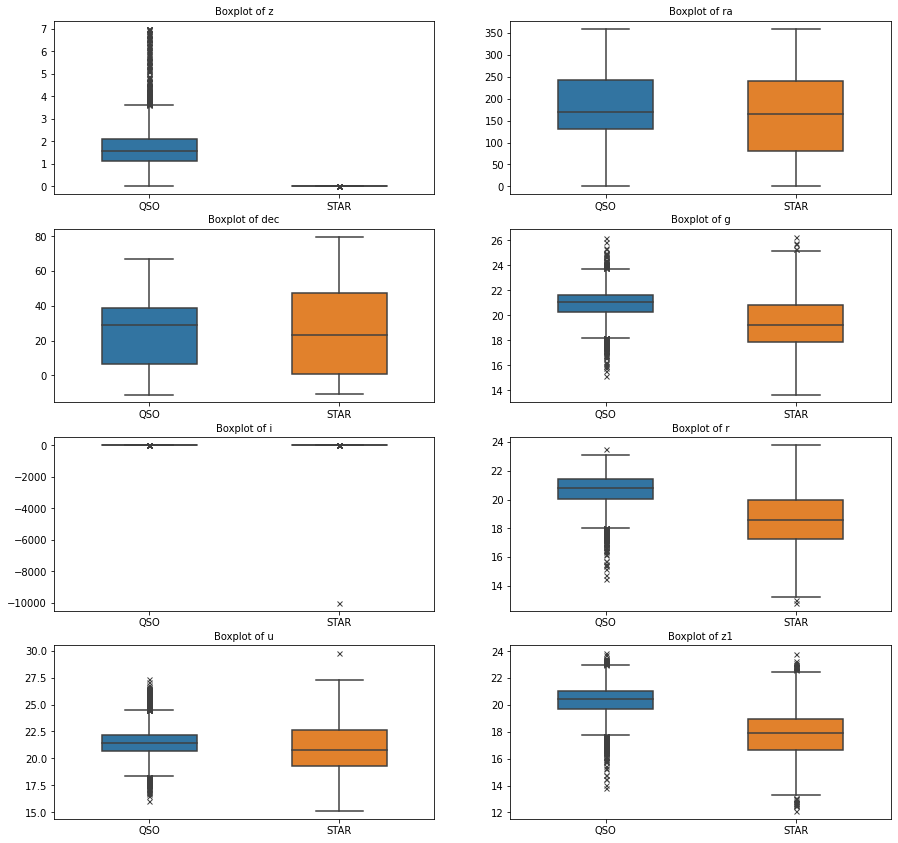

In [19]:
box_plotter(df=df, features=main_cols, target='class')

Vediamo come, nella banda 'i' sia presente un outliers anomalo nel cluster di stelle, probabilmente associabile ad una presa dati poco accurata in banda 'i', è quindi utile individuare tale dato ed eliminarlo dal nostro dataframe.

In [20]:
display(df[df['i'] == min(df['i'])][main_cols + ['class']])

,z,ra,dec,g,i,r,u,z1,class
6600,-0.000383,334.209899,70.03263,16.24309,-9999.0,15.09408,18.71041,14.26493,STAR


In [21]:
index= df[df['i'] == min(df['i'])].index.to_list()[0]

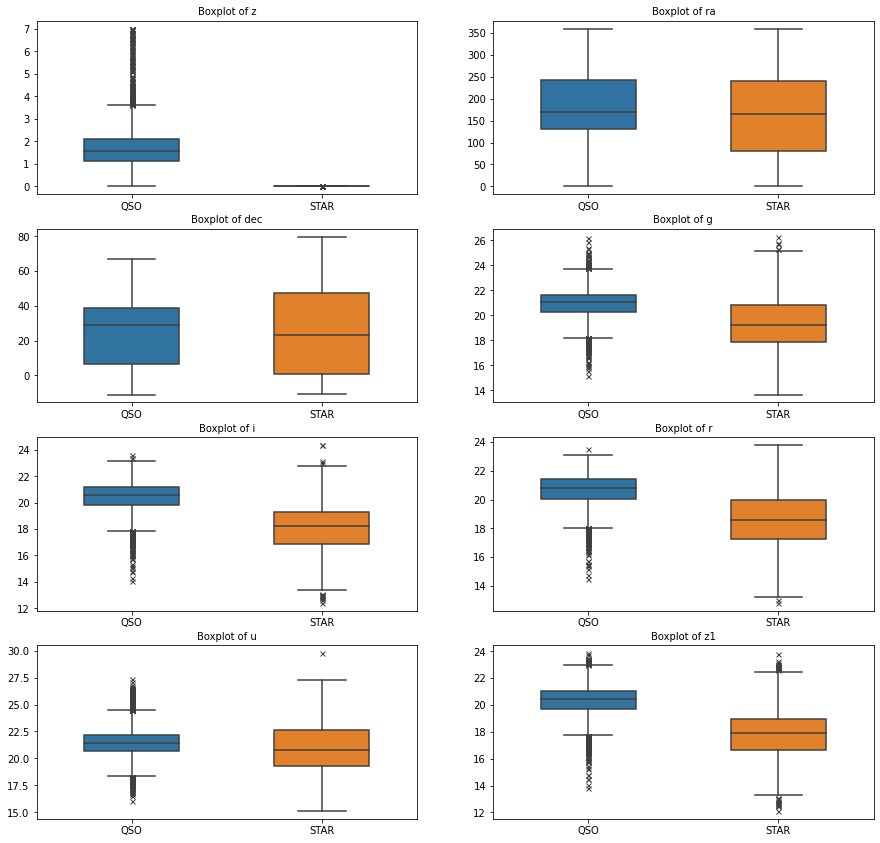

In [22]:
df = df.drop(index=[index])
box_plotter(df=df, features=main_cols, target='class')

Dai vari Boxplot, oltre alla presenza di ulteriori outliers nelle diverse bande, risulta utile osservare come il redshift delle stelle mostra valore 0. Questo vuol dire che affinché il nostro modello possa categorizzare in maniera corretta un dato come "STAR" , quest'ultimo dovrebbe presentare redshift nullo o non troppo distante dallo zero.

Scegliamo, inoltre, di non eliminare dal dataframe nessuno degli outliers visibili dai vari boxplots dal momento che, la loro presenza, potrebbe suggerire una maggior variabilità dei dati e potrebbero tornare utili per verificare la robustezza del nostro modello. 

####**2.2.2 PDF : Probability Density Function**
I plot di densità sono delle rappresentazioni grafiche della PDF di un cluster di dati. 

Come i dati sono distribuiti nel nostro dataframe è inidicato dalla PDF. Come possiamo facilmente notare dai plot sottostanti, le PDF dei vari parametri fisici delle due catogrie in esame, eccenzion fatta per il redshift, si sovrappongono, ciò vuol dire che un modello di regressione lineare potrebbe presentare una scarsa accuratezza.

In [23]:
def pdf_plotter(df, features, target):
    plt.figure(figsize=(15, 30))
    for (i, feature) in zip(range(len(features)), features):
        plt.subplot(int('{}2{}'.format(len(features), i+1)))
        sns.kdeplot(data=df, x=feature, hue=target, shade=True)
        plt.title(label='PDF of {}'.format(feature), fontsize=10)
        plt.xlabel(xlabel='')
        plt.grid()
        i += 1
    plt.show()

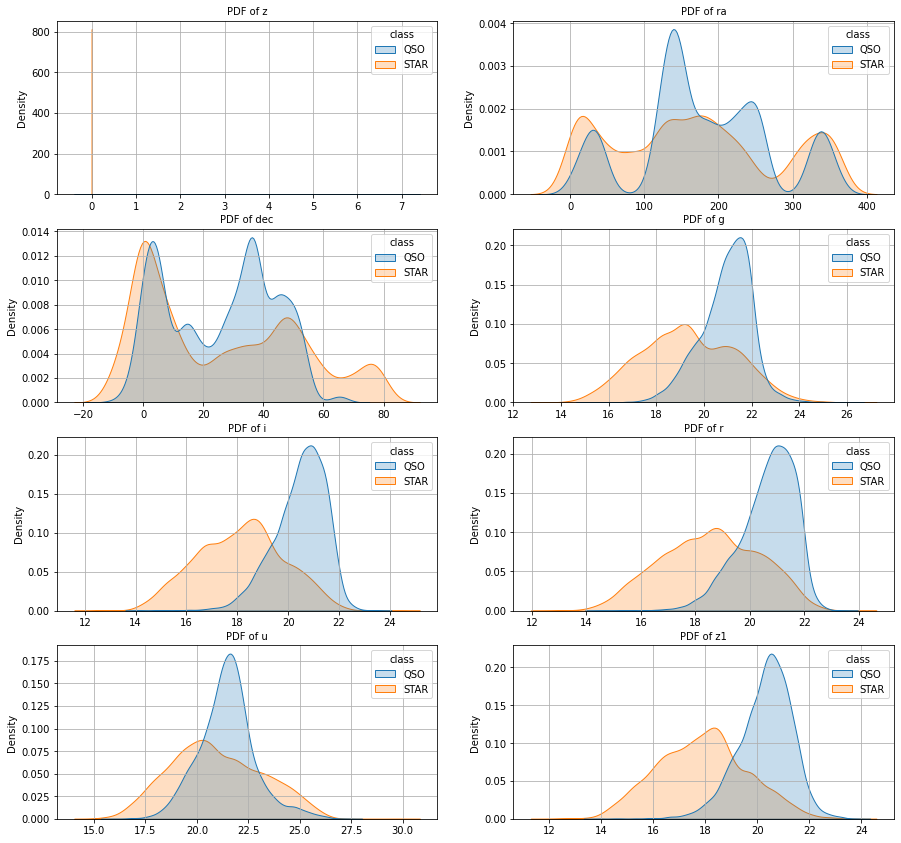

In [24]:
pdf_plotter(df=df, features=main_cols, target='class')

##**3. La Support Vector Machine**

Procediamo quindi alla creazione dell'algoritmo di apprendimento automatico usando la Support Vector Machine (SVM). 

A tale scopo si importeranno le funzioni della libreria sklearn (scikit-learn).

Si estraggono le variabili di input 'X' e quelle di output 'y'. 
La variabile 'y' è il target che il nostro modello dovrà essere in grado di prevedere, le variabili 'X' saranno quelle utilizzate dal modello per effettuare le previsioni.

Viene, quindi, definito il modello (SVM) e vengono utilizzati i parametri di default della funzione.

Si sfrutta il metodo di cross-validation per valutare le performance del modello. Nel dettaglio si sfrutta la cross-validation k-fold, ciò vuol dire che il set di dati verrà suddiviso in k parti uguali, verrà addestrato su k-1 set e testato sull'ultimo. Ciò verrà ripetuto k volte in modo che ogni parte del set di dati sia utilizzata per la valutazione del modello.

In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
y = df['class']
X = df.drop(['class', 'run', 'obj','index','zErr','plate','zWarning','field','obj','mjd'], axis=1)
model = SVC(probability = True)
n_folds = 5
kfold = KFold(n_splits=n_folds)
y

0         QSO
1         QSO
2        STAR
3         QSO
4        STAR
         ... 
18931    STAR
18932     QSO
18933    STAR
18934    STAR
18935    STAR
Name: class, Length: 18935, dtype: object

Dal momento che la variabile 'y' contiene i label delle varie classi, e dal momento che i modelli di apprendimento automatico sfruttano variabili solo in formato numerico, la libreria label encoder trasforma i label 'QSO' e 'STAR' rispettivamente in 0 ed 1.

In [26]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [27]:
classi = list(le.classes_)

Si suddividono, quindi, i dati in training set e test set tramite la funzione train_test_split() di scikit-learn. Tale funzione ha come parametri i Dataframe di input ed output; il test_size che permette di fissare le dimensioni del test set, in questo caso è fissato al 30% delle dimensioni del dataframe totale; stratify che ci assicura che la proporzione delle classi sia la stessa nel training e nel test set; random_state è invece un parametro utile a fissare il seed per la generazione di numeri casuali usati nell'estrazione casuale degli esempi di training e di test.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=35, stratify= y)

Effettuaimo quindi una standardizzazione delle variabili, portandole tutte a media nulla e varianza unitaria. Tale passaggio risulta fondamentale nelle tecniche di Machine Learning per evitare che il modello venga influenzato in maniera più significativa da una sola variabile rispetto alle altre.

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled

array([[-1.22314281, -0.82122084,  0.        , ...,  0.29725497,
        -0.24419453, -0.14191374],
       [ 0.22636818,  2.13211906,  0.        , ...,  0.71494367,
         0.58810384,  7.10645421],
       [ 1.10588918,  1.57687951,  0.        , ...,  0.50699817,
         0.61074456, -0.14191287],
       ...,
       [-0.21150493,  0.38601195,  0.        , ...,  0.14780987,
         0.94808808, -0.14191287],
       [-0.226604  ,  1.01512617,  0.        , ..., -0.16820672,
         0.87392685, -0.14191287],
       [-1.35903446, -0.82086031,  0.        , ..., -2.26307058,
        -2.39274204, -0.14191374]])

Si addestra ora la SVM sui dati di training e viene utilizzata la cross-validation per la valutazione delle prestazioni del modello. Il parametro score_method specifica il metodo di valutazione del modello, in particolare viene utilizzata l'accuratezza. Il risultato restituito  è l'accuratezza media del modello sulle diverse combinazioni delle parti di training set e di test set, e la deviazione standard corrispondente.

In [30]:
model.fit(X_train_scaled, y_train)
score_method= 'accuracy'
cross_score = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring=score_method)
print("Accuratezza: {:.2f} (+/- {:.2f})".format(cross_score.mean(), cross_score.std() * 2))

Accuratezza: 0.99 (+/- 0.00)


Viene poi utilizzato il modello così costruito per fare una previsione dei label sui dati di training.

In [31]:
y_train_predicted= model.predict(X_train_scaled)

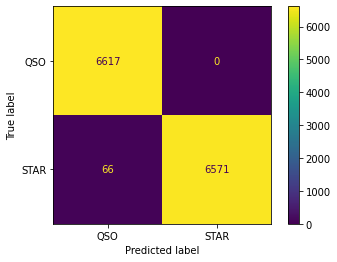

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_train_predicted, y_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = classi)
disp.plot()
plt.show()

In [33]:
a_train = accuracy_score(y_train, y_train_predicted)
print('Accuratezza sul test set: {:.3f}'.format(a_train))

Accuratezza sul test set: 0.995


Addestrato il nostro modello possiamo procedere al test di quest'ultimo sfruttando i dati del test set.

In [34]:
X_test_scaled = scaler.transform(X_test)
y_test_predicted = model.predict(X_test_scaled)

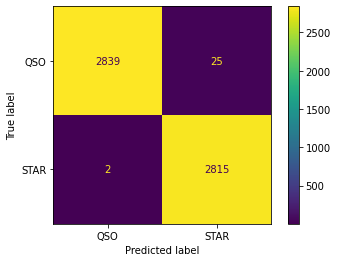

In [35]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = classi )
disp.plot()
plt.show()

Possiamo pensare di valutare l'accuratezza del nostro modello:

In [36]:
a_test = accuracy_score(y_test, y_test_predicted)
print('Accuratezza sul test set: {:.3f}'.format(a_test))

Accuratezza sul test set: 0.995


Tuttavia, utilizzare l'accuratezza come parametro per la stima della bontà del nostro modello non risulta ottimale: tramite una sola analisi del redshift delle due classi è quasi certo che si riesca ad individuare correttamente la classe di appartenenza dell'oggetto in esame. Risulta, quindi, utile sfruttare altri parametri statistici per la corretta valutazione circa la bontà dei nostri dati: **Purezza** (o **Precision**), **Completezza** (o **Recall**) ed **F1-score**.

Ma cosa indicano effettivamente questi tre parametri statistici nel nostro caso ? 

* Purezza : tale parametro indica la proporzione di istanze classificate come QSO dal modello che sono effettivamente QSO. Una precision elevata indica che il modello ha classificato correttamente la maggior parte delle istanze come QSO.

* Completezza : il recall o completezza è un indice della proporzione di istanze QSO correttamente classificate dal modello rispetto al totale delle istanze QSO presenti nel set di dati. Un recall elevato indica che il modello ha identificato correttamente la maggior parte delle istanze QSO.

* F1 : è definita come media armonica tra i due parametri appena descritti. È una metrica che tiene conto sia della precisione che del recall e quindi fornisce una valutazione complessiva delle prestazioni del modello. L'F1-score è utile quando si desidera bilanciare la precisione e il recall, ad esempio, quando le classi non sono bilanciate.

In [37]:
report_test = classification_report(y_test, y_test_predicted, digits=3, target_names= classi)
print(report_test)

              precision    recall  f1-score   support

         QSO      0.999     0.991     0.995      2864
        STAR      0.991     0.999     0.995      2817

    accuracy                          0.995      5681
   macro avg      0.995     0.995     0.995      5681
weighted avg      0.995     0.995     0.995      5681



Come possiamo vedere i parametri di purezza (precision), di entrambe le classi,sono più che accettabili. E' interessante notare come anche il parametro di completezza (recall) risulti essere estremamente elevato. Questo risultato potrebbe essere indice di un modello con delle elevate prestazioni. Tuttavia, per evitare di trarre conclusioni erronee bisogna prendere in considerazioni anche altri parametri statistici. Alla luce di ciò è utile fare riferimento anche alla colonna ove viene riportato il valore dell'f1-score, anch'esso pari a 0.99.

##**4. Conclusioni**

Grazie allo studio iniziale dei dati, è stato possibile eliminare dal dataset tutte quelle osservazioni che non erano in linea con le nostre condizioni di qualità fotometrica. Una seconda analisi dei dati ci ha permesso di individuare una rilevazione in banda 'i' anomala per il cluster di stelle che è stata successivamente scartata dal nostro dataset. 

Tutte queste accortezze hanno reso possibile l'assemblaggio di un modello di Support Vector Machine che fosse in grado di distinguere con un ottima affidabilità le due categorie in esame. L'obiettivo principale da noi proposto era, infatti, quello di essere in grado di avere una purezza del dataset di QSO quanto migliore possibile. Un notevole sottoprodotto della nostra analisi e pulizia dati è l'ottenimento di un elevato punteggio anche per la metrica di completezza delle nostre due classi. 

Tuttavia, valori così alti di tali parametri potrebbero indurre ad una erronea valutazione del classificatore utilizzato. E' risultato, quindi, necessario ricorrere alla stima di un terzo parametro per un'ulteriore conferma sulla bontà del modello: l F1-score, anch'esso con un punteggio estremamente elevato. 
Un'ulteriore check potrebbe effettuarsi tramite un'ulteriore metrica: la **Curva ROC** (Receiver Operating Characteristic) maggiore è l'area sottesa da tale curva maggiore sarà la bontà del nostro modello.


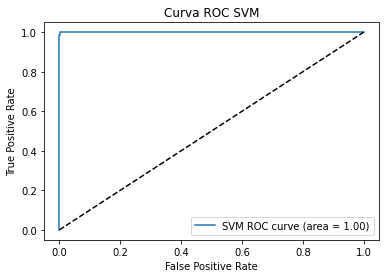

In [38]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_test_proba = model.predict_proba(X_test_scaled)
y_test_scores = y_test_proba[: , 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_scores)
auc = roc_auc_score(y_test, y_test_scores)
plt.plot(fpr, tpr, label=f'SVM ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC SVM')
plt.legend(loc='lower right')
plt.show()

In conclusione, è possibile affermare con certezza la bontà del modello utilizzato per la classificazione e la sua capacità di riportare un campione di classificazione notevolmente "puro" (o preciso). Ciò è associabile, oltre che alla gestione dati precedentemente descritta, anche ad una marcata distizione tra i parametri fisici degli oggetti in esame: un qso presenta, in media, un valore di redshift più elevato rispetto al valore medio assunto nel nostro campione di stelle. Altra distinzione è da ricercare nelle magnitudini nelle diverse bande, un qso presenta una magnitudine assoluta superiore rispetto a quella di una stella.